gen	evals	std                               	min                               	avg                               	max                               
0  	92   	[0.55497504 0.55085423 0.60846925]	[0.0023818  0.0052794  0.01045613]	[0.77457113 0.7657523  1.09498158]	[2.34698573 2.08965808 2.35117313]
1  	92   	[0.66109631 0.59427095 0.54644065]	[0.0023818  0.00500467 0.01045613]	[0.81115657 0.77418947 0.80697984]	[2.43175892 1.92419669 1.999819  ]
2  	92   	[0.69845906 0.58626725 0.50893605]	[0.00057289 0.0026966  0.00517944]	[0.81548949 0.72577014 0.65591532]	[2.43175892 2.08694199 1.69634914]
3  	92   	[0.66454297 0.55109864 0.48296417]	[0.00057289 0.00263192 0.00517944]	[0.82266617 0.65175447 0.60633966]	[2.21889655 2.04433683 1.69634914]
4  	92   	[0.59045966 0.5286927  0.48374764]	[7.60715052e-05 1.92777678e-03 5.17943630e-03]	[0.67213688 0.65895137 0.59604015]	[1.89529357 1.80851674 1.69634914]
5  	92   	[0.57358062 0.51963142 0.46166066]	[7.60715052e-05 1.92777678e-03 4.03139929e-

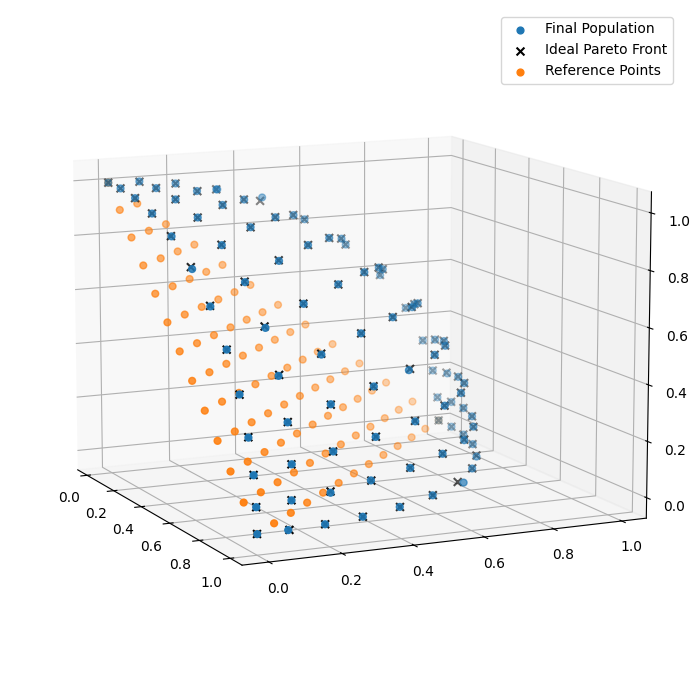

In [2]:
from math import factorial
import random

import matplotlib.pyplot as plt
import numpy
import pymop.factory

from deap import algorithms
from deap import base
from deap.benchmarks.tools import igd
from deap import creator
from deap import tools

# Problem definition
PROBLEM = "dtlz2"
NOBJ = 3
K = 10
NDIM = NOBJ + K - 1
P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))
BOUND_LOW, BOUND_UP = 0.0, 1.0
problem = pymop.factory.get_problem(PROBLEM, n_var=NDIM, n_obj=NOBJ)
##

# Algorithm parameters
MU = int(H + (4 - H % 4))
NGEN = 400
CXPB = 1.0
MUTPB = 1.0
##

# Create uniform reference point
ref_points = tools.uniform_reference_points(NOBJ, P)

# Create classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ)
creator.create("Individual", list, fitness=creator.FitnessMin)
##


# Toolbox initialization
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox = base.Toolbox()
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", problem.evaluate, return_values_of=["F"])
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=30.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("select", tools.selNSGA3, ref_points=ref_points)
##


def main(seed=None):
    random.seed(seed)

    # Initialize statistics object
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean, axis=0)
    stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"

    pop = toolbox.population(n=MU)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Compile statistics about the population
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print(logbook.stream)

    # Begin the generational process
    for gen in range(1, NGEN):
        offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Select the next generation population from parents and offspring
        pop = toolbox.select(pop + offspring, MU)

        # Compile statistics about the new population
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print(logbook.stream)

    return pop, logbook


if __name__ == "__main__":
    pop, stats = main()
    pop_fit = numpy.array([ind.fitness.values for ind in pop])

    pf = problem.pareto_front(ref_points)
    print(igd(pop_fit, pf))

    import matplotlib.pyplot as plt
    import mpl_toolkits.mplot3d as Axes3d

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection="3d")

    p = numpy.array([ind.fitness.values for ind in pop])
    ax.scatter(p[:, 0], p[:, 1], p[:, 2], marker="o", s=24, label="Final Population")

    ax.scatter(pf[:, 0], pf[:, 1], pf[:, 2], marker="x", c="k", s=32, label="Ideal Pareto Front")

    ref_points = tools.uniform_reference_points(NOBJ, P)

    ax.scatter(ref_points[:, 0], ref_points[:, 1], ref_points[:, 2], marker="o", s=24, label="Reference Points")

    ax.view_init(elev=11, azim=-25)
    ax.autoscale(tight=True)
    plt.legend()
    plt.tight_layout()
    plt.show()